Install and load required libraries

In [ ]:
!pip install datasets
!pip install transformers

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader
from transformers import get_scheduler
import torch
from transformers import BertModel
import torch.nn as nn

load the data

In [2]:
data_files={"test":"data/test.csv","train":"data/train.csv","val":"data/val.csv"}
raw_data_dict=load_dataset("csv",data_files=data_files)
raw_data_dict

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['label', 'sentence'],
        num_rows: 1821
    })
    train: Dataset({
        features: ['label', 'sentence'],
        num_rows: 6920
    })
    val: Dataset({
        features: ['label', 'sentence'],
        num_rows: 872
    })
})

tokenizing the text

In [3]:
checkpoint="bert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [4]:
def tokenize(example):
    return tokenizer(example['sentence'],truncation=True)

In [5]:
tokenized_datadict= raw_data_dict.map(tokenize, batched=True)
tokenized_datadict

  0%|          | 0/7 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1821
    })
    train: Dataset({
        features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6920
    })
    val: Dataset({
        features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
})

In [6]:
tokenized_datadict =tokenized_datadict.remove_columns(["sentence", "token_type_ids"])
tokenized_datadict = tokenized_datadict.rename_column("label", "labels")
tokenized_datadict

DatasetDict({
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1821
    })
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6920
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 872
    })
})

In [7]:
tokenized_datadict.set_format("torch")

load data into DataLoader to train

In [8]:
train_loader=DataLoader(tokenized_datadict["train"], shuffle=True, batch_size=128, collate_fn=data_collator)
test_loader=DataLoader(tokenized_datadict["test"], shuffle=True, batch_size=128, collate_fn=data_collator)
dev_loader=DataLoader(tokenized_datadict["val"], shuffle=True, batch_size=128, collate_fn=data_collator)

load the model 

In [9]:
from Emodel import EfficientTransformer


In [17]:
model=EfficientTransformer(checkpoint,256)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


we move our model to GPU which accelerate our training.
and we define our loss-function for binary classification and our optimizer.

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
loss_function= nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

we define a function which count how many predictions we make are right. Its an accuracy function

In [19]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()  
    acc = correct.sum().item()
    return acc

In [37]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train_data(model, train_loader,optimizer, loss_function, clip, train_history=None, valid_history=None):
    model.train()
    history = []
    epoch_loss=0
    epoch_accuracy=0
    data_num=0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(batch["input_ids"].to(device),batch["attention_mask"].to(device)).squeeze(1)
        
        loss = loss_function(outputs, batch["labels"].float().to(device))
        epoch_loss+=loss
        # print("epoch_accuracy is ",epoch_accuracy*100,"%")
        epoch_accuracy+=binary_accuracy(outputs,batch["labels"].to(device) )
        data_num+=128
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
    
    epoch_loss=epoch_loss.item()
    epoch_accuracy/=data_num
    
    return epoch_accuracy, epoch_loss

In [38]:
def eval_data(model, dev_loader,loss_function):
    model.eval()
    
    epoch_loss = 0
    epoch_accuracy=0
    data_num=0
    history = []
    with torch.no_grad():
        for batch in dev_loader:
            outputs = model(batch["input_ids"].to(device),batch["attention_mask"].to(device)).squeeze(1)
            loss = loss_function(outputs, batch["labels"].float().to(device))
            epoch_loss+=loss
            epoch_accuracy+=binary_accuracy(outputs,batch["labels"].to(device) )
            data_num+=128

    epoch_loss=epoch_loss.item()
    epoch_accuracy/=data_num

    return epoch_accuracy, epoch_loss

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
train_history = []
valid_history = []
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

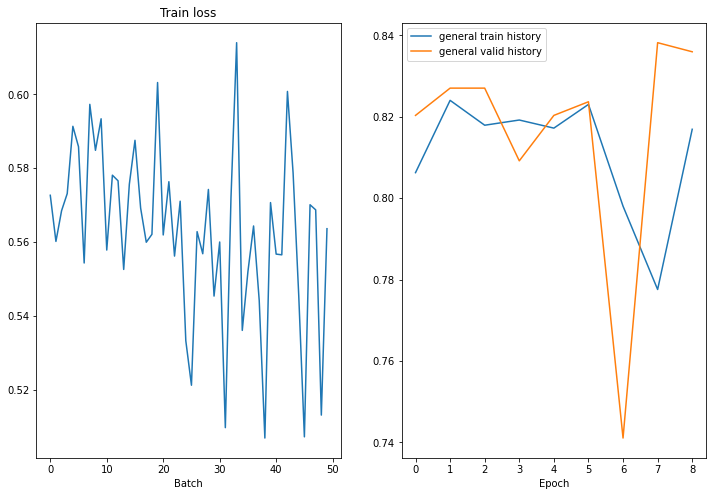

Epoch: 10 | Time: 0m 28s
	Train Loss: 31.079 | Train Acc: 0.8311079545454545
	 Val. Loss: 3.960 |  Val. Acc: 0.8337053571428571


In [41]:
import time
N_EPOCHS = 10
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_acc, train_loss = train_data(model, train_loader,optimizer, loss_function, CLIP, train_history, valid_history)
    valid_acc, val_loss = eval_data(model, dev_loader, loss_function)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), 'model/best-model.pt')

    train_history.append(train_acc)
    valid_history.append(valid_acc)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc}')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {valid_acc}')

After 10 epochs we have a accuracy of 83% on validation set

load the best model

In [ ]:
model = EfficientTransformer(checkpoint,256)
model.load_state_dict(torch.load('./model/best-model.pt'))
model.eval()

In [45]:
# Initialize variables to store the total number of examples and the number of correct predictions
total_examples = 0
correct_predictions = 0
epoch_accuracy=0
data_num=0
model.to(device)

# Iterate over the test data loader
for batch in test_loader:
    # Get the input and labels
    predictions = model(batch["input_ids"].to(device),batch["attention_mask"].to(device)).squeeze(1)
    correct_predictions+=binary_accuracy(predictions,batch["labels"].to(device) )
    data_num+=128

# Calculate the accuracy by dividing the number of correct predictions by the total number of examples
accuracy = correct_predictions / data_num

# Print the accuracy
print("Accuracy on test dataset: {:.2f}%".format(accuracy * 100))


Accuracy on test dataset: 80.57%


The accuracy on test dataset is 80%

In [46]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 723,457 trainable parameters
